This notebook loads in unfiltered, unwrapped igrams and breaks time series up into a few time intervals, inverts for displacement rate for each pixel during each time period. 

This notebook: <br>
1. loads in unfilt unwrapped igrams OR filt unwrapped igrams 
2. references each igram to (A) the average of the whole igram, and (B) the average phase value within a small reference region
3. Fit a line to each disp history at each pixel (unweighted disp rates)

This notebook was written on 12-04-22. Edited 1-31-23.

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib  widget

Do we want to run this notebook with filtered/unfiltered data? <br>
What about referenced to average phase value, reference box, or reference pixels chosen by "chooseing_reference_pixels.ipynb"

In [2]:
# choose one 
key1 = 'filt'
#key1 = 'unfilt'
# choose one 
key2 = 'avg_val'
key2 = 'ref_box'
key2 = 'ref_pix'

Read in unfiltered or filtered (depending on key defined above), unwrapped igrams. Can take a few minutes.

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')

if key1 == 'unfilt':
    # igramsDir is where the cropped, unwrapped igrams are 
    igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
    # loop through the dates 
    for i in range(numIgrams): # numIgrams if doing all of them at once
        date1=dates[i]
        date2=dates[i+1]
        igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    print('unfiltered unwrapped igrams loaded.')

if key1 == 'filt':
    # igramsDir is where the cropped, unwrapped igrams are 
    igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/filt_unwrapped/'
    # loop through the dates 
    for i in range(numIgrams): # numIgrams if doing all of them at once
        date1=dates[i]
        date2=dates[i+1]
        igramFile = igramsDir+date1+'_'+date2+'_filt.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    print('filtered unwrapped igrams loaded.')

filtered unwrapped igrams loaded.


Load in the mask for reference pixels chosen with 4 criteria. 

In [4]:
# load reference pixels mask 
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

Reference pixel mask loaded.


Now plot a sample interferogram with reference box or pixels shown if referencing either of those ways.

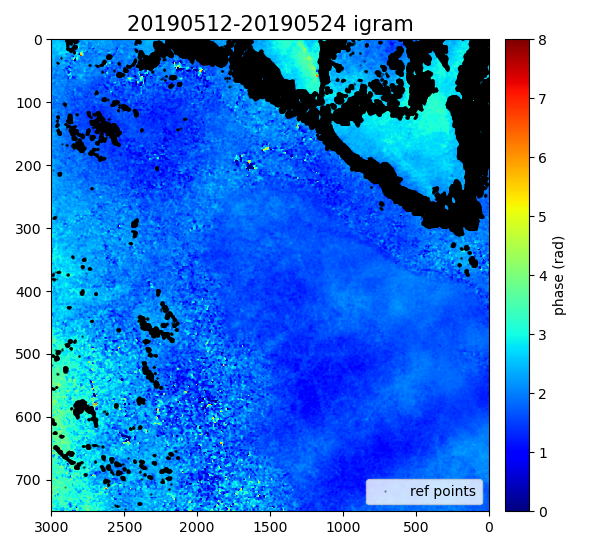

In [5]:
#k = 15 # which igram to plot? 
k = 59
date1 = dates[k]; date2 = dates[k+1]
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=0,vmax=8)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0]) #plt.xticks([]); plt.yticks([])
plt.title(str(date1)+'-'+str(date2)+' igram',fontsize=15)
if key2 == 'ref_box':
    plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='yellow',facecolor='none',linewidth=2,label='ref box'))
    plt.legend()
if key2 == 'ref_pix':
    plt.plot(mask_x,mask_y,'k.',ms=1,alpha=0.5,label='ref points')
    plt.legend()
plt.show()

Reference all the unwr_full_res igrams. Options according to key2:
1. average value (subtract avg value of each igram from each pixel in that igram)
2. box of pixels
3. pixels chosen based on criteria outlined in 'choosing_reference_pixels.ipynb'

In [6]:
# correct all igrams so there's a zero/stationary point 
# initialize an array for corrected igrams
unwr_full_res_cor = np.ndarray(np.shape(unwr_full_res),dtype='float')
if key2 == 'avg_val':
    for i in range(numIgrams):
        # remove the average phase from igram
        # (choosing that we assume no deformation across entire image, reference to the average value)
        unwr_full_res_cor[i] = unwr_full_res[i]-np.mean(unwr_full_res[i])
    print('igrams corrected by subtracting avg value.')
if key2 == 'ref_box':
    for i in range(numIgrams):
        # remove the average phase from small reference region at foot of mountains   
        unwr_full_res_cor[i] = unwr_full_res[i]-np.mean(unwr_full_res[i,150:180,800:900])
    print('igrams corrected by subtracting avg value over small reference region in mountains.')
if key2 == 'ref_pix':
    for i in range(numIgrams):
        unwr_full_res_cor[i] = unwr_full_res[i]-np.mean(unwr_full_res[i,mask_y,mask_x])
    print('igrams corrected by subtracting avg value of reference pixels chosen with 4 criteria.')

igrams corrected by subtracting avg value of reference pixels chosen with 4 criteria.


In [7]:
# if need to save RAM space, delete the original igrams here.
del unwr_full_res

Pull out dates in order to plot the time series

In [3]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# take numIgrams and pull out the igram_dates, corresponding to the first day of each igram
igram_dates = slc_dates[0:-1]

# Convert igram_dates to the number of days and then years to fit a line with 
igram_dates_floatyrs = np.ndarray((numIgrams,),dtype='float')
for i in range(numIgrams):
    igram_dates_floatyrs[i] = (igram_dates[i]-igram_dates[0]).days/365.25

print('slc_dates: '+str(np.shape(slc_dates)))
print('igram_dates: '+str(np.shape(igram_dates)))
print('igram dates converted to floats.')

NameError: name 'dates' is not defined

Find which dates I need to separate the time series into to fit slopes for each pixel.

In [9]:
# for i in np.arange(45,55,1):
#     print(str(i)+'  '+str(dates[i]))
    
print('first time period: '+str(dates[0])+'-'+str(dates[46]))
print('second time period: '+str(dates[47])+'-'+str(dates[107]))
print('third time period: '+str(dates[108])+'-'+str(dates[146]))
print('fourth time period: '+str(dates[147])+'-'+str(dates[-1]))
print(str(dates[numIgrams]))

print('\ntime period overlapping with Jiang and Lohman: '+str(dates[0])+'-'+str(dates[88]))
print('total duration of this study: '+str((igram_dates[-1]-igram_dates[0]).days/365.25)+' years')

start_indices = [0,47,108,147,0,0]
end_indices = [46,107,146,numIgrams,88,numIgrams]
num_intervals = len(start_indices)

first time period: 20170510-20181125
second time period: 20181207-20200412
third time period: 20200418-20201208
fourth time period: 20201214-20220108
20220108

time period overlapping with Jiang and Lohman: 20170510-20191220
total duration of this study: 4.632443531827516 years


Now calculate an average UNWEIGHTED displacement rate for each pixel in my region for time intervals defined above. Extract time series at one pixel btw two dates, convert it to cm and do cumulative sum, then fit a line to it, then put the rate (slope of the best-fit line) into an array and plot the array. <br><br>
This next cell usually takes ~35 minutes to run (so far).

In [10]:
# initialize array to hold disp rates for each point, for each time interval 
disp_rates = np.ndarray((num_intervals,dy,dx),dtype='float') 

# make a conversion factor from radians to cm. Next two lines repetitive, copied from earlier code cell. 
wavelength = 5.5465763
rad2cm = wavelength/(4*np.pi) # this is conversion factor that I multiply by the data (which is in rads)

# Start the loop here
for j in range(num_intervals): #num_intervals for all of them
    # pick out from igram_dates_floatyrs which dates I'm using for this interval 
    igram_dates_interval = igram_dates_floatyrs[start_indices[j]:end_indices[j]]
    # loop through pixels 
    for y in range(dy):
        for x in range(dx):
            # pull out time series at the pixel 
            disp_rates_temp = unwr_full_res_cor[start_indices[j]:end_indices[j],y,x]  
            # convert it to cm and cumulative sum it 
            cum_disp_temp_cm = np.cumsum(disp_rates_temp)*rad2cm
            # now fit a line to this. m is slope, b is intercept
            m, b = np.polyfit(igram_dates_interval, cum_disp_temp_cm, 1)
            # put that rate into the avg_disp_rates array 
            disp_rates[j,y,x] = m
    print('avg disp rates calculated for interval '+str(j))
print('\ndone.')

avg disp rates calculated for interval 0
avg disp rates calculated for interval 1
avg disp rates calculated for interval 2
avg disp rates calculated for interval 3
avg disp rates calculated for interval 4
avg disp rates calculated for interval 5

done.


In [11]:
print(key1,key2)

filt ref_pix


Save those disp maps for each time interval so I don't have to run previous cell every time 

In [12]:
# Save these as isce-readable files so I don't have to run that each time 
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
driver=gdal.GetDriverByName('ISCE')

for i in range(num_intervals): # range(num_intervals)
    if key1 == 'unfilt':
        if key2 == 'avg_val':
            name_file_this = 'interval_'+str(i)+'_ref_to_avg.r4'
        if key2 == 'ref_box':
            name_file_this = 'interval_'+str(i)+'_ref_to_box.r4'
        if key2 == 'ref_pix':
            name_file_this = 'interval_'+str(i)+'_ref_to_pix.r4'
    if key1 == 'filt':
        if key2 == 'avg_val':
            name_file_this = 'interval_'+str(i)+'_filt_ref_to_avg.r4'
        if key2 == 'ref_box':
            name_file_this = 'interval_'+str(i)+'_filt_ref_to_box.r4'
        if key2 == 'ref_pix':
            name_file_this = 'interval_'+str(i)+'_filt_ref_to_pix.r4'
    colds = driver.Create(saveDir+name_file_this,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates[i])
    colds=None
print('Files saved.')

Files saved.


Read in the corrected igram files here (don't have to run the previous two cells)

In [15]:
# read in files if not saved in output
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
disp_rates = np.ndarray((num_intervals,dy,dx),dtype='float') 

# can choose different files to read in as above since that code made the files and this is reading them in.
key1 = 'filt'
#key1 = 'unfilt'
# choose one 
#key2 = 'avg_val'
key2 = 'ref_box'
#key2 = 'ref_pix'

for i in range(num_intervals): # range(num_intervals)
    if key1 == 'unfilt':
        if key2 == 'avg_val':
            file_name = 'interval_'+str(i)+'_ref_to_avg.r4'
        if key2 == 'ref_box':
            file_name = 'interval_'+str(i)+'_ref_to_box.r4'
        if key2 == 'ref_pix':
            file_name = 'interval_'+str(i)+'_ref_to_pix.r4'
    if key1 == 'filt':
        if key2 == 'avg_val':
            file_name = 'interval_'+str(i)+'_filt_ref_to_avg.r4'
        if key2 == 'ref_box':
            file_name = 'interval_'+str(i)+'_filt_ref_to_box.r4'
        if key2 == 'ref_pix':
            file_name = 'interval_'+str(i)+'_filt_ref_to_pix.r4'
    f1 = gdal.Open(saveDir+file_name, gdal.GA_ReadOnly)
    disp_rates[i] = f1.ReadAsArray()
f1 = None
print('Files of disp rate maps loaded.')

Files of disp rate maps loaded.


Plot a time series at a point (point f from 2-point comparisons) and show the line of best fit for it to demonstrate an unweighted fit.

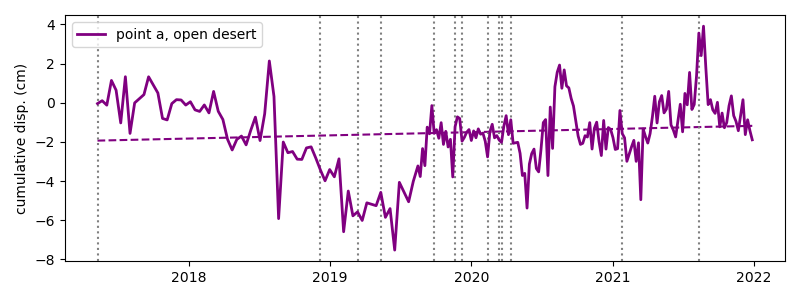

-0.5194303351801466
0.16283272263877943


In [11]:
# make a conversion factor from radians to cm. Next two lines repetitive, copied from earlier code cell. 
wavelength = 5.5465763
rad2cm = wavelength/(4*np.pi) # this is conversion factor that I multiply by the data (which is in rads)

#comparepoint = [350,1500]  # f, green 
plt.figure(figsize=(8,3),tight_layout='TRUE')
color_to_use = 'tab:green'
disp_f = np.cumsum(unwr_full_res_cor_2[:,350,1500])*rad2cm
disp_a = np.cumsum(unwr_full_res_cor_2[:,500,2500])*rad2cm

m_f, b_f = np.polyfit(igram_dates_floatyrs, disp_f, 1)
line_f = m_f*igram_dates_floatyrs + b_f
m_a, b_a = np.polyfit(igram_dates_floatyrs, disp_a, 1)
line_a = m_a*igram_dates_floatyrs + b_a

# Read in 2day precipitation data and pick out rain dates
precip = np.loadtxt('/data/ocp4/LagunaSalada/Data_and_Figs/3_precip/precip_2days.txt', dtype='float')
# print('i \tdate \t\t       precip > 0.0cm')
rain_dates = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.0:
        #print(str(i)+'\t'+str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])

plt.plot(igram_dates,disp_f,color='tab:green',linewidth=2,label='point f, LS',zorder=15) # purple,tab:orange,tab:green,tab:blue
plt.plot(igram_dates,disp_a,color='purple',linewidth=2,label='point a, open desert',zorder=15)
plt.plot(igram_dates,line_f,color='tab:green',linestyle='--')
plt.plot(igram_dates,line_a,color='purple',linestyle='--')

yval = -10.0
linewid = 10.0
plt.hlines(yval,igram_dates[0],igram_dates[46],color='gold',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[47],igram_dates[107],color='hotpink',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[108],igram_dates[146],color='olive',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[147],igram_dates[-1],color='coral',linewidth=linewid,zorder=10)
plt.hlines(yval-1.0,igram_dates[0],igram_dates[88],color='cornflowerblue',linewidth=linewid,zorder=10)

Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.legend(); #loc='upper left'
#plt.title('Cum. disp. btw sets of '+str(num_pixels)+' pixels (rad)')
plt.ylabel('cumulative disp. (cm)'); #plt.xlabel('date')
plt.show()
#plt.savefig("time_series_g-h.pdf", transparent=True)
print(m_f)
print(m_a)

Just plot the timeline of intervals for velocity fitting 

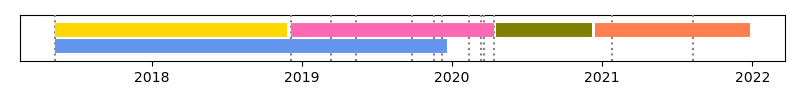

In [12]:
plt.figure(figsize=(8,1),tight_layout='TRUE')
yval = -10.0
linewid = 10.0
plt.hlines(yval,igram_dates[0],igram_dates[46],color='gold',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[47],igram_dates[107],color='hotpink',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[108],igram_dates[146],color='olive',linewidth=linewid,zorder=10)
plt.hlines(yval,igram_dates[147],igram_dates[-1],color='coral',linewidth=linewid,zorder=10)
plt.hlines(yval-1.5,igram_dates[0],igram_dates[88],color='cornflowerblue',linewidth=linewid,zorder=10)

Ymin,Ymax = -13,-8.5 #plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.yticks([])
plt.show()

Now plot them. Make sure that the difference between referencing to (1) igram average vs. (2) a smaller stable region in the mountains actually makes a difference. The results should be slightly different (and they are!)

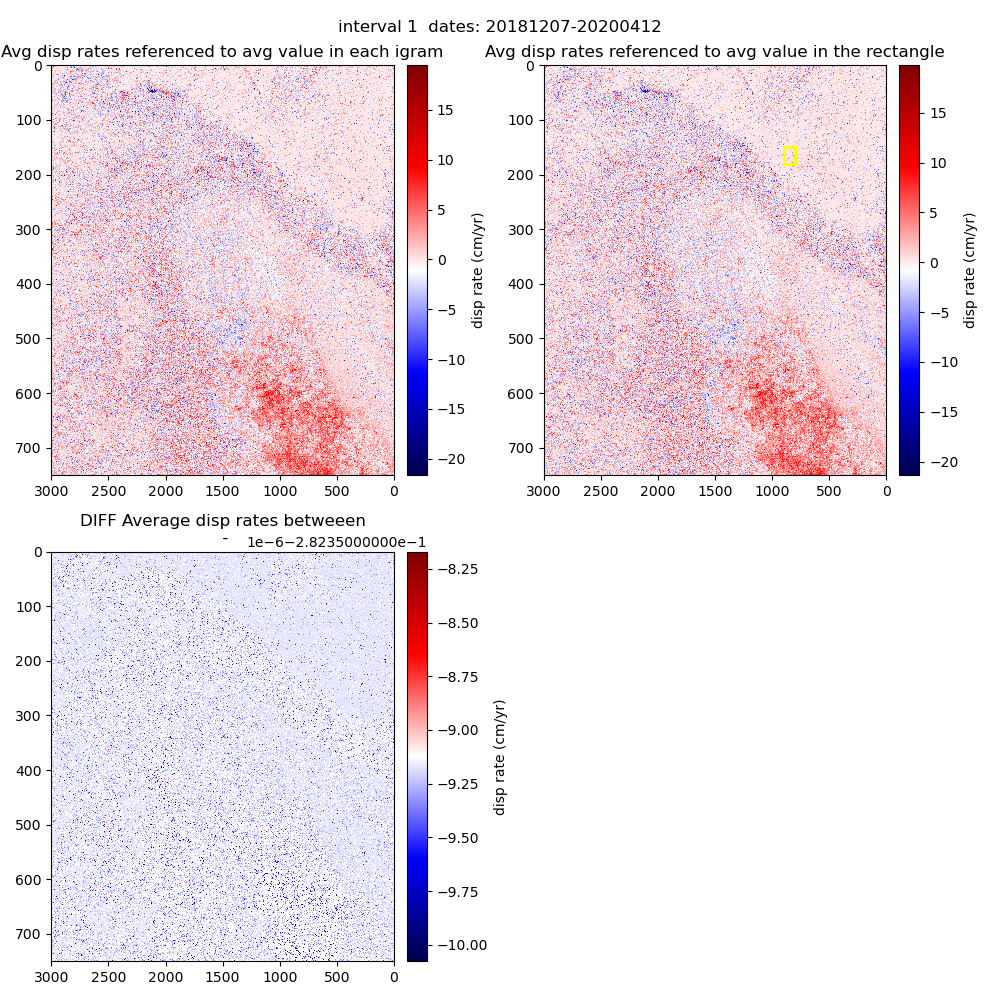

In [13]:
i = 1 # this is which time interval (there are five) you want to plot
plt.figure(figsize=(10,10),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(disp_rates[i], aspect='auto', \
            interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.03,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
title = str('Avg disp rates referenced to avg value in each igram')
plt.title(title,fontsize=12)
#plt.xlabel('range'); plt.ylabel('azimuth'); plt.xticks([]); plt.yticks([])
plt.subplot(2,2,2)
plt.imshow(disp_rates_2[i], aspect='auto', \
            interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.03,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]);plt.ylim([dy,0])
title = str('Avg disp rates referenced to avg value in the rectangle')
plt.title(title,fontsize=12)
#plt.xlabel('range'); plt.ylabel('azimuth'); plt.xticks([]); plt.yticks([])
# add a box for reference region
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='yellow',facecolor='none',linewidth=2))
plt.subplot(2,2,3)
plt.imshow(disp_rates[i]-disp_rates_2[i], aspect='auto', \
            interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.03,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
title = str('DIFF Average disp rates betweeen\n -')
plt.title(title,fontsize=12)
#plt.xlabel('range'); plt.ylabel('azimuth'); plt.xticks([]); plt.yticks([])
plt.suptitle('interval '+str(i)+'  dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()
#plt.savefig("disp_rates_period_1-2.png", transparent=True)

Plot all the disp rate maps for each interval.

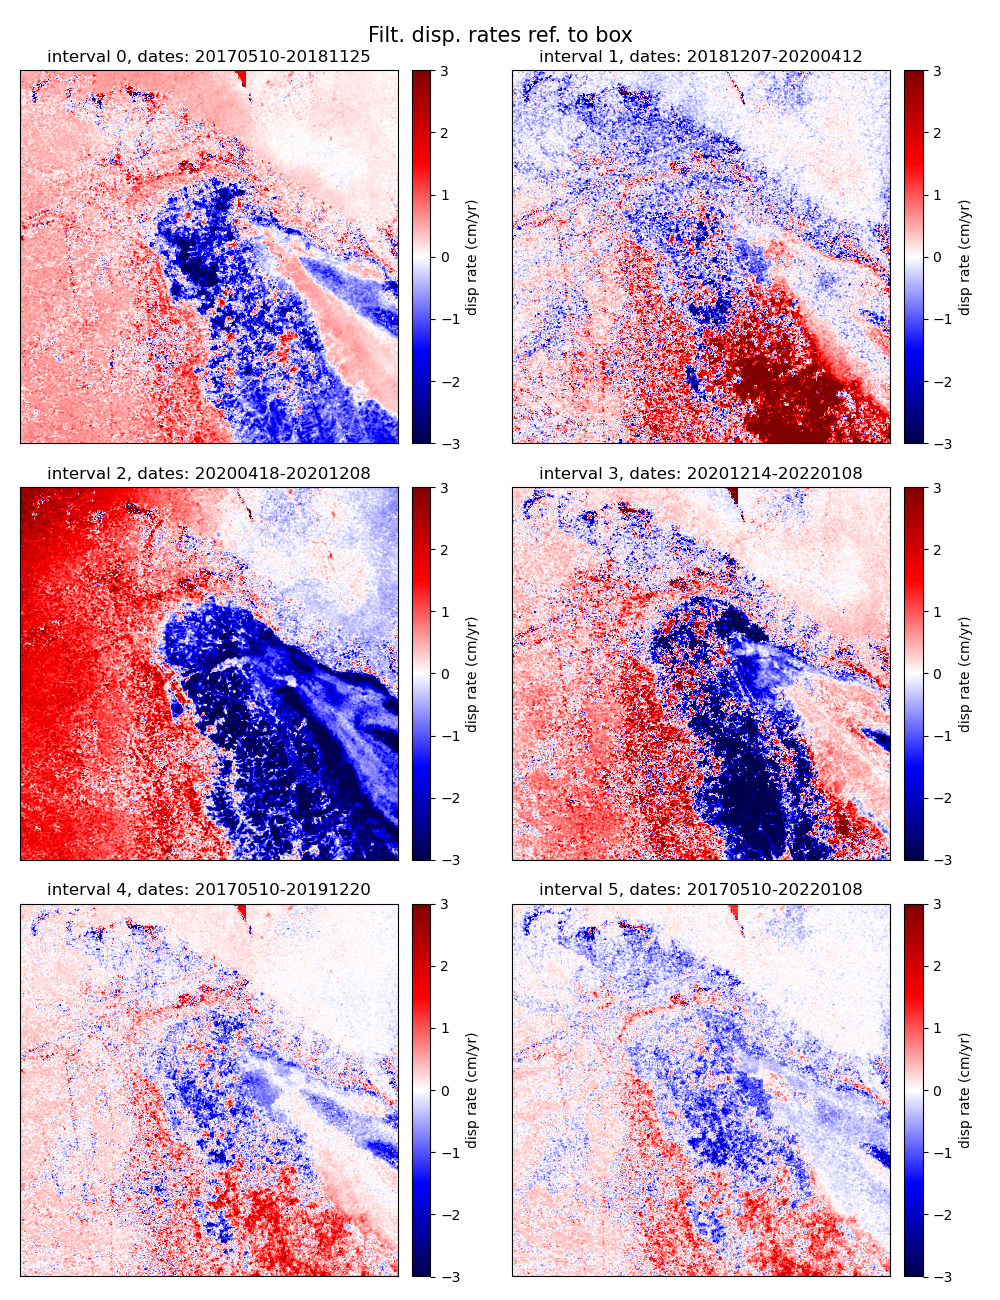

In [16]:
plt.figure(figsize=(10,13),tight_layout=True)
count = 1
for i in range(num_intervals):
    plt.subplot(3,2,count)
    plt.imshow(disp_rates[i], aspect='auto', vmin=-3.0, vmax=3.0,  \
                interpolation='nearest', extent = [0,dx,dy,0])
    plt.colorbar(orientation='vertical',pad=0.03,label='disp rate (cm/yr)')
    plt.set_cmap('seismic')
    plt.xlim([dx,0]); plt.ylim([dy,0])
    plt.xticks([]); plt.yticks([])
    title = str('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
    plt.title(title,fontsize=12)
    count = count+1
if key1 == 'unfilt':
    if key2 == 'avg_val':
        title = 'Disp. rates ref. to igram avg. value'
    if key2 == 'ref_box':
        title = 'Disp. rates ref. to box'
    if key2 == 'ref_pix':
        title = 'Disp. rates ref. to pixels'
if key1 == 'filt':
    if key2 == 'avg_val':
        title = 'Filt. disp. rates ref. to igram avg. value'
    if key2 == 'ref_box':
        title = 'Filt. disp. rates ref. to box'
    if key2 == 'ref_pix':
        title = 'Filt. disp. rates ref. to pixels'
plt.suptitle(title,fontsize=15)
plt.show()

Just plot one interval at a time. 

interval 2, dates: 20200418-20201208


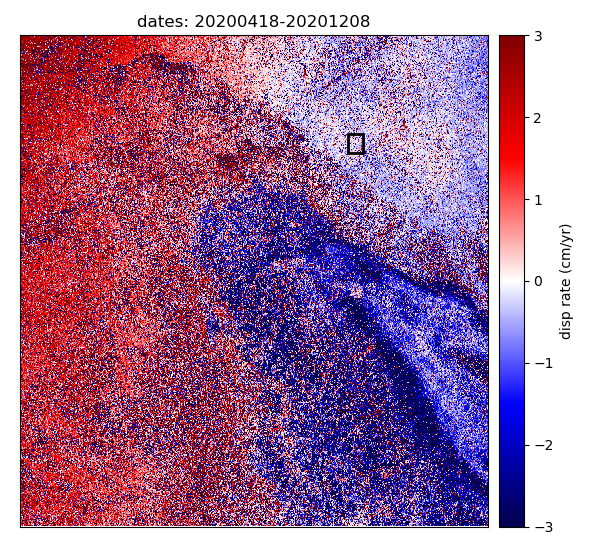

In [53]:
i = 2 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates[i], aspect='auto', vmin=-3.0, vmax=3.0,  \
            interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='k',facecolor='none',linewidth=2))
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()
#plt.savefig("disp_rates_period_1-2.png", transparent=True)